<a href="https://colab.research.google.com/github/Lilhxr/leaf_detect/blob/main/SWIN_CASSAVA_PRETRAINED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd '/content/drive/MyDrive/cassava-deit-swin/'

In [ ]:
!pip install --no-deps albumentations==1.0.0 # image argumentation
!pip install timm # pytorch image models

In [15]:
from __future__ import print_function, division
from albumentations.pytorch import ToTensorV2
from datetime import datetime
from pathlib import Path
from sklearn.metrics import confusion_matrix
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torch.optim import Adam, AdamW 
from torch.optim.lr_scheduler import ExponentialLR 
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

import albumentations as A
import gc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import timm
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import random
from functools import partial

import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [5]:
from pathlib import Path
sys.path.insert(0,os.path.abspath('./'))
sys.path.insert(0,os.path.abspath('./utilities'))

In [6]:
from utilities.utils import *

In [7]:
import timm

In [ ]:
timm.list_models(pretrained=True)

## Vit_16 on Cassava

In [9]:
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

In [10]:
LABEL = 'SWIN_TINY_CASSAVA'
TYPE = 'PRETRAINED'

## Getting the hooks for each layers

In [11]:
hookLayersActivationDict = {}
activationDict = {}

In [12]:
modelNamedModules = dict(model.named_modules())

In [16]:
def feature_dimension_extractor(model):

    feature_dimension = {}
    input = torch.randn(16, 3, 224, 224)

    def hook_fn(name, module, input, output):
        feature_dimension[name] = output.size()

    for name, layer in model.named_modules():
        # hook_fn(module, input, output)
        layer.register_forward_hook(partial(hook_fn, name))
    _ = model(input)

    return feature_dimension 

In [18]:
feature_dimension = feature_dimension_extractor(model)
hookLayers = [k for k, v in feature_dimension.items() if v[0] == 16]

In [ ]:
hookLayers

In [20]:
for layer in hookLayers:
    h = model.get_submodule(layer).register_forward_hook(getActivation(layer,hookLayersActivationDict))

## Cassava

In [ ]:
IMAGE_SIZE = 224
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
NUM_WORKERS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

class Transforms:
    def __init__(self, transforms: A.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))

train_augs_compose = A.Compose([
    A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.Normalize(    
        mean=IMAGENET_DEFAULT_MEAN,
        std=IMAGENET_DEFAULT_STD),
    A.CoarseDropout(p=0.5),
    ToTensorV2(),
])

valid_augs_compose = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),
    A.Normalize(
        mean=IMAGENET_DEFAULT_MEAN,
        std=IMAGENET_DEFAULT_STD),
    ToTensorV2(),
])

train_augs = Transforms(train_augs_compose)
valid_augs = Transforms(valid_augs_compose)

In [22]:
class CustomizedDataset(Dataset):
     '''convert ImageFolder to torchvision Dataset'''

     def __init__(self, dataset):
         self.dataset = dataset
         self.classes = self.dataset.classes
         self.targets = self.dataset.targets

     def __getitem__(self, index):
         img, lb = self.dataset[index]
         return (img['image'], lb)
     
     def __len__(self):
         return len(self.dataset)

In [23]:
train_data = CustomizedDataset(ImageFolder("./data/cassava_leaf_data/train", transform=train_augs))

class_sample_counts = np.empty(len(train_data.classes), dtype=int)
for idx in range(len(train_data.classes)):
    class_sample_counts[idx] = train_data.targets.count(idx)

weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
samples_weights = weights[train_data.targets]

# data balancer
sampler = data.WeightedRandomSampler(
    weights=samples_weights,
    num_samples=len(samples_weights),
    replacement=True)

train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS)

In [24]:
validation_data = CustomizedDataset(ImageFolder("./data/cassava_leaf_data/test", transform=valid_augs))
val_loader = DataLoader(validation_data, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [25]:
test_data = CustomizedDataset(ImageFolder("./data/cassava_leaf_data/test", transform=valid_augs))
test_loader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
model = model.to(device)
valid_acc,activationDict = evaluate(model,device,val_loader,hookLayers,hookLayersActivationDict)

Iteration:   0%|          | 0/118 [00:10<?, ?it/s]


## HSIC calculation and plots

In [28]:
col1, col2, hsicScoreList = getLayerWiseOutputCorrelation(hookLayers,hookLayers,activationDict,activationDict)

In [29]:
import pandas as pd
import seaborn as sns

In [30]:
import matplotlib.ticker as ticker

In [31]:
hsicData = {
    'L1' : col1,
    'L2' : col2,
    'hsic':hsicScoreList
}

hsicDataFrame = pd.DataFrame(data=hsicData)
hsicDataFrame = hsicDataFrame.pivot("L1", "L2", "hsic")

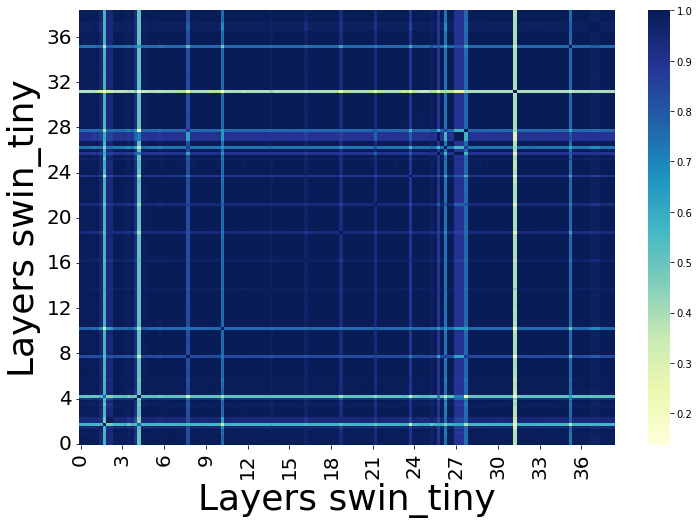

In [33]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(hsicDataFrame.T, cmap='YlGnBu')
plt.xlabel("Layers swin_tiny",fontsize='36')
plt.ylabel("Layers swin_tiny",fontsize='36')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xticks(ax.get_xticks()[::4])
ax.set_yticks(ax.get_yticks()[::4])
ax.invert_yaxis()
plt.savefig(LABEL+"_"+TYPE+'.pdf',fmt='pdf',bbox_inches='tight')